(240, 240, 155)


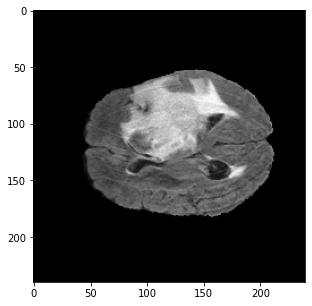

(240, 240, 155)


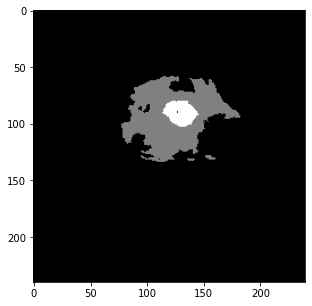

(240, 240, 155)


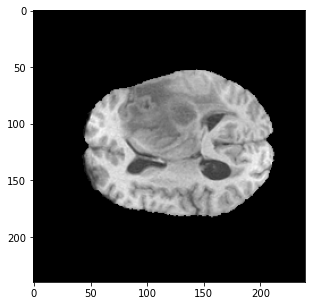

(240, 240, 155)


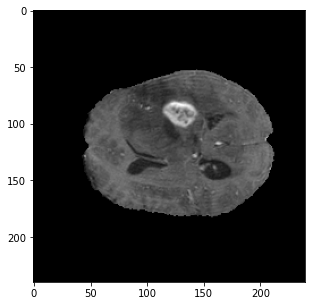

(240, 240, 155)


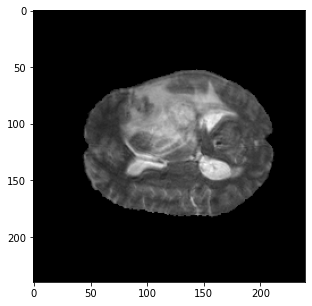

(240, 240, 155)


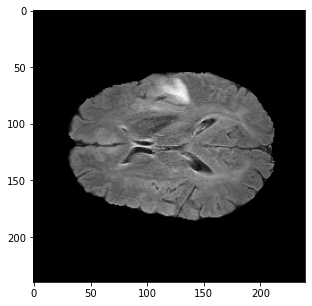

(240, 240, 155)


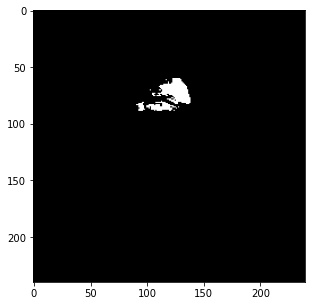

(240, 240, 155)


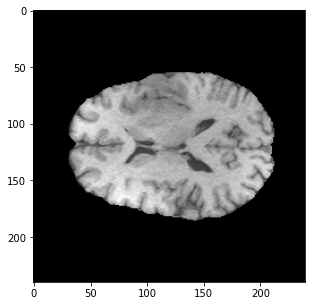

(240, 240, 155)


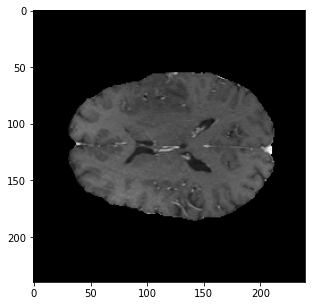

(240, 240, 155)


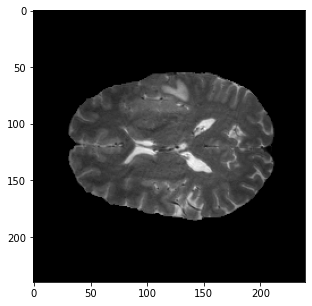

(240, 240, 155)


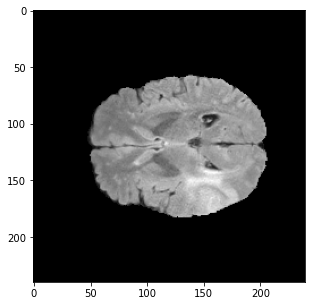

(240, 240, 155)


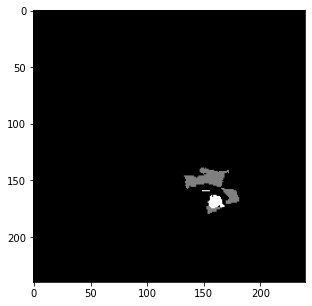

(240, 240, 155)


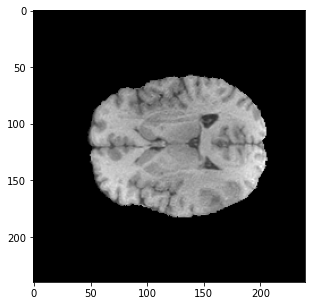

(240, 240, 155)


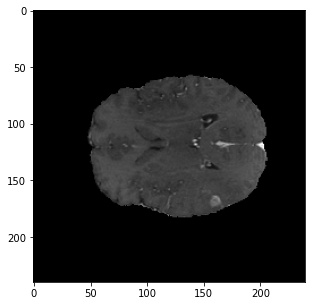

(240, 240, 155)


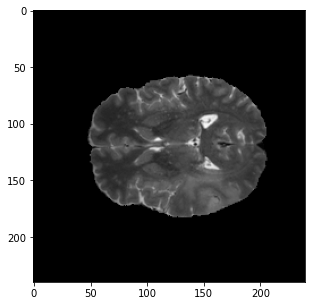

(240, 240, 155)


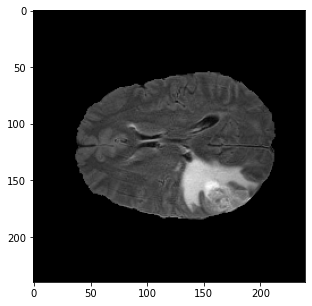

(240, 240, 155)


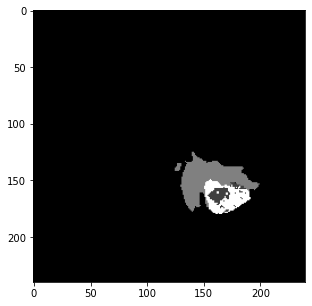

(240, 240, 155)


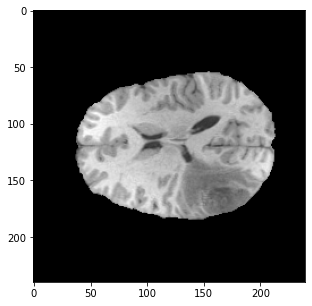

(240, 240, 155)


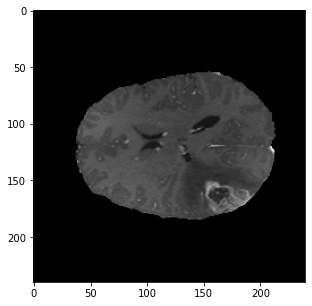

(240, 240, 155)


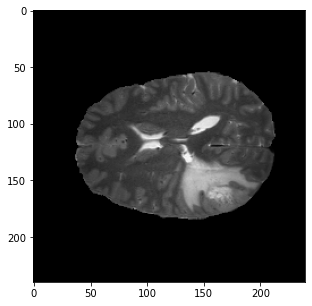

(240, 240, 155)


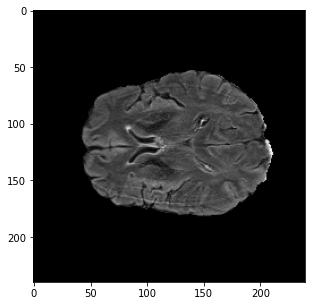

(240, 240, 155)


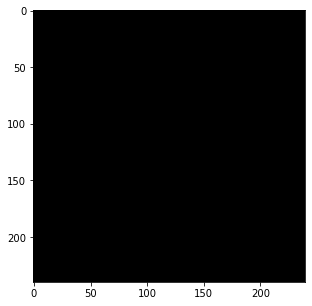

(240, 240, 155)


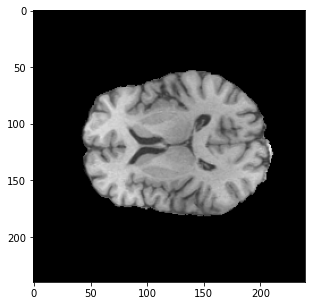

(240, 240, 155)


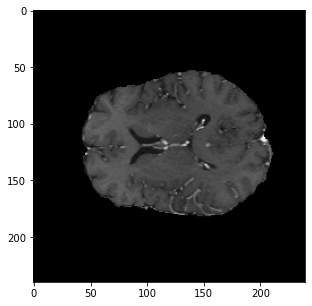

(240, 240, 155)


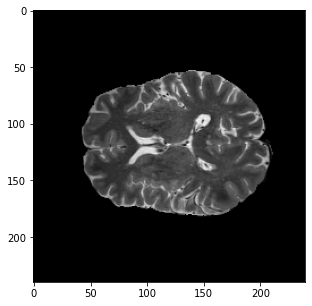

(240, 240, 155)


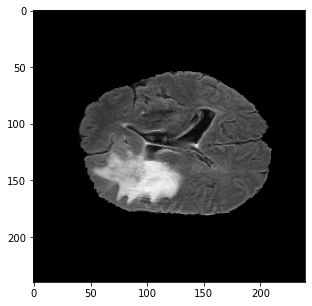

(240, 240, 155)


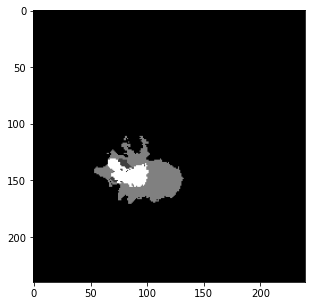

(240, 240, 155)


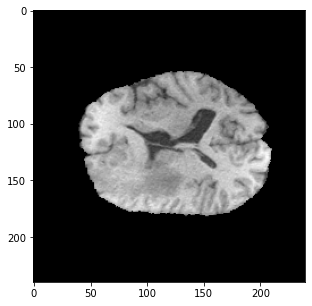

(240, 240, 155)


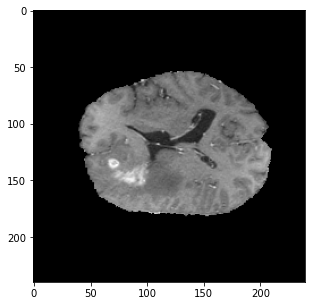

(240, 240, 155)


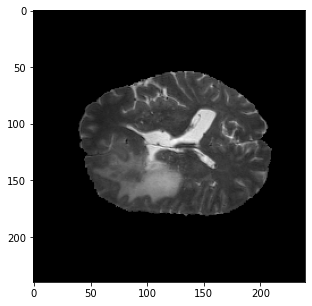

(240, 240, 155)


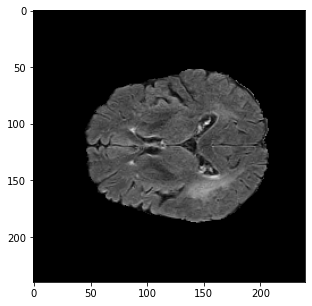

(240, 240, 155)


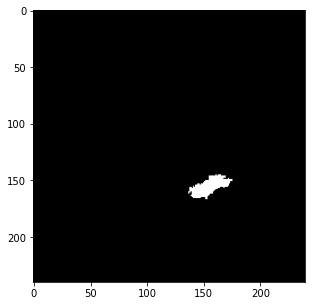

(240, 240, 155)


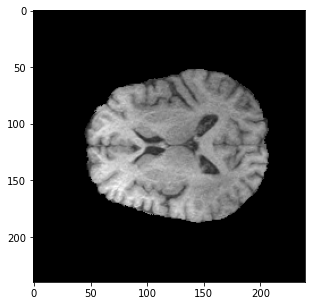

(240, 240, 155)


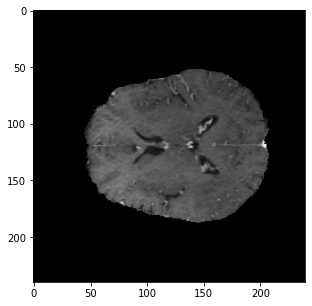

(240, 240, 155)


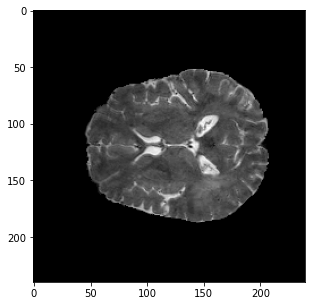

(240, 240, 155)


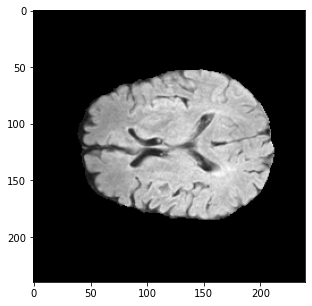

(240, 240, 155)


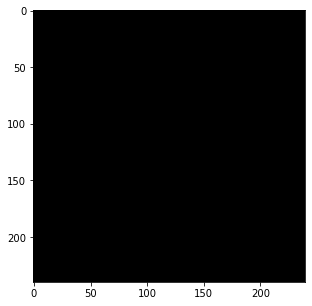

(240, 240, 155)


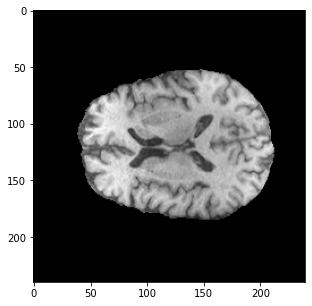

(240, 240, 155)


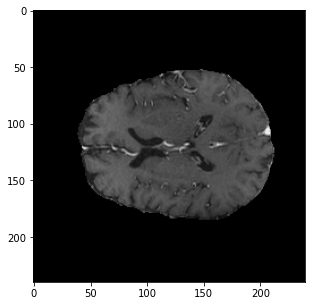

(240, 240, 155)


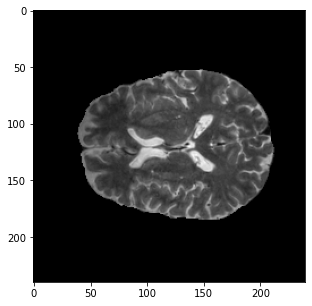

(240, 240, 155)


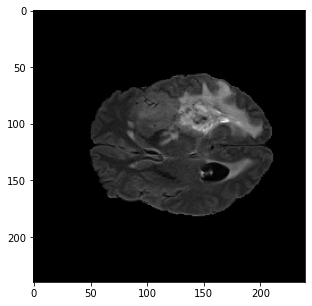

(240, 240, 155)


KeyboardInterrupt: 

In [5]:
from collections import defaultdict

from medpy.io import load
import os
import numpy as np
import torch

import random
from copy import deepcopy
from scipy.ndimage import map_coordinates, fourier_gaussian
from scipy.ndimage.filters import gaussian_filter, gaussian_gradient_magnitude
from scipy.ndimage.morphology import grey_dilation
from skimage.transform import resize
from scipy.ndimage.measurements import label as lb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import SimpleITK as sitk
# from utilities.file_and_folder_operations import subfiles
def subfiles(folder,res, join=True, prefix=None, suffix=None, sort=True):
    # if join:
    #     l = os.path.join
    # else:
    #     l = lambda x, y: y
    # for i in os.listdir(folder):
    #     print(i)
    # res = [l(folder, i) for i in os.listdir(folder) if os.path.isfile(os.path.join(folder, i))
    #         and (prefix is None or i.startswith(prefix))
    #         and (suffix is None or i.endswith(suffix))]
    
    dirList=[]
    for i in os.listdir(folder):
        wholepath = os.path.join(folder, i)
        if os.path.isdir(wholepath):
            dirList.append(wholepath)
        if os.path.isfile(wholepath):
            res.append(wholepath)
            if not wholepath.endswith(suffix):
                res.remove(wholepath)
    if dirList:
        for subDir in dirList:
            subfiles(subDir,res,join=False,suffix=".nii.gz")
    if sort:
        res.sort()
    
    
def pad_nd_image(image, new_shape=None, mode="constant", kwargs=None, return_slicer=False, shape_must_be_divisible_by=None):
    """
    one padder to pad them all. Documentation? Well okay. A little bit
    :param image: nd image. can be anything
    :param new_shape: what shape do you want? new_shape does not have to have the same dimensionality as image. If
    len(new_shape) < len(image.shape) then the last axes of image will be padded. If new_shape < image.shape in any of
    the axes then we will not pad that axis, but also not crop! (interpret new_shape as new_min_shape)
    Example:
    image.shape = (10, 1, 512, 512); new_shape = (768, 768) -> result: (10, 1, 768, 768). Cool, huh?
    image.shape = (10, 1, 512, 512); new_shape = (364, 768) -> result: (10, 1, 512, 768).
    :param mode: see np.pad for documentation
    :param return_slicer: if True then this function will also return what coords you will need to use when cropping back
    to original shape
    :param shape_must_be_divisible_by: for network prediction. After applying new_shape, make sure the new shape is
    divisibly by that number (can also be a list with an entry for each axis). Whatever is missing to match that will
    be padded (so the result may be larger than new_shape if shape_must_be_divisible_by is not None)
    :param kwargs: see np.pad for documentation
    """
    if kwargs is None:
        kwargs = {'constant_values': 0}

    if new_shape is not None:
        old_shape = np.array(image.shape[-len(new_shape):])
    else:
        assert shape_must_be_divisible_by is not None
        assert isinstance(shape_must_be_divisible_by, (list, tuple, np.ndarray))
        new_shape = image.shape[-len(shape_must_be_divisible_by):]
        old_shape = new_shape

    num_axes_nopad = len(image.shape) - len(new_shape)

    new_shape = [max(new_shape[i], old_shape[i]) for i in range(len(new_shape))]

    if not isinstance(new_shape, np.ndarray):
        new_shape = np.array(new_shape)

    if shape_must_be_divisible_by is not None:
        if not isinstance(shape_must_be_divisible_by, (list, tuple, np.ndarray)):
            shape_must_be_divisible_by = [shape_must_be_divisible_by] * len(new_shape)
        else:
            assert len(shape_must_be_divisible_by) == len(new_shape)

        for i in range(len(new_shape)):
            if new_shape[i] % shape_must_be_divisible_by[i] == 0:
                new_shape[i] -= shape_must_be_divisible_by[i]

        new_shape = np.array([new_shape[i] + shape_must_be_divisible_by[i] - new_shape[i] % shape_must_be_divisible_by[i] for i in range(len(new_shape))])

    difference = new_shape - old_shape
    pad_below = difference // 2
    pad_above = difference // 2 + difference % 2
    pad_list = [[0, 0]]*num_axes_nopad + list([list(i) for i in zip(pad_below, pad_above)])

    if not ((all([i == 0 for i in pad_below])) and (all([i == 0 for i in pad_above]))):
        res = np.pad(image, pad_list, mode, **kwargs)
    else:
        res = image

    if not return_slicer:
        return res
    else:
        pad_list = np.array(pad_list)
        pad_list[:, 1] = np.array(res.shape) - pad_list[:, 1]
        slicer = list(slice(*i) for i in pad_list)
        return res, slicer


def preprocess_data(root_dir='/home/jovyan/main/BraTS2020_TrainingData/', y_shape=64, z_shape=64):
    # image_dir = os.path.join(root_dir, 'imagesTr')
    image_dir = root_dir
    label_dir = os.path.join(root_dir, 'labelsTr')
    output_dir = os.path.join(root_dir, 'preprocessed')
    classes = 4

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print('Created' + output_dir + '...')

    class_stats = defaultdict(int)
    total = 0
    nii_files=[]
    subfiles(image_dir,nii_files, suffix=".nii.gz", join=False)

    # for i in range(0, len(nii_files)):
    #     if nii_files[i].startswith("._"):
    #         nii_files[i] = nii_files[i][2:]
    # print("--------")

    for f in nii_files:
        # print(os.path.join(image_dir, f))
        # image, _ = load(os.path.join(image_dir, f))
        # label, _ = load(os.path.join(label_dir, f.replace('_0000', '')))
        image,metadata=load(f)
        print(image.shape)
        # plt.imshow(image, cmap = cm.Greys_r)
        # print(1,image)
        label=metadata.get_sitkimage()
        # npImage = sitk.GetArrayFromImage(label)
        # print(2,npImage)
        z = int(label.GetSize()[2]/2)
        plt.figure(figsize=(5,5))
        plt.imshow(image[:,:,z], 'gray')
        plt.show()
        
preprocess_data()